# Homework 2

In [1]:
from bs4 import BeautifulSoup
from collections import Counter
from difflib import SequenceMatcher
from pandas.plotting import scatter_matrix
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
import requests
import unidecode
%config InlineBackend.figure_format = 'retina'

## 1. Getting the data from the Top Universities website
By using Postman we realize that the following [URL](https://www.topuniversities.com/sites/default/files/qs-rankings-data/357051_indicators.txt) is called when we try to fetch the top universities. We can see here that when we get it using requests, all of the data is here by JSON and we use it to get our information. 

In [2]:
URL = "https://www.topuniversities.com/sites/default/files/qs-rankings-data/357051_indicators.txt"
r = requests.get(URL)
r_as_json = r.json()

We need to retrieve the name, rank, country and region, number of faculty members (international and total) and number of students (international and total) for each university in the top 200 list, let's do that. First we saw by looking at the website that there is a university in the first top 200 that is out of place, we will remove it later. For now we then take the first 201 universities.

In [3]:
# The JSON is ordered by number of ranking
# So we can directly cut it as we wish
ranking = r_as_json['data'][:201]

# We directly have access to the Name, Rank, 
# Country, Region directly from the JSON.
TOP_UNIVERSITIES = "https://www.topuniversities.com"

def get_infos(ranked_uni):
    """
    Returns all of the needed informations and
    the link to the details page

    Returns the name, rank, country, region
    and details page of each ranked uni
    """
    soup = BeautifulSoup(ranked_uni['uni'], 'html.parser')
    result = {}
    result['Name'] = soup.text
    result['Rank'] = int(ranked_uni['overall_rank'])
    result['Country'] = ranked_uni['location']
    result['Region'] = ranked_uni['region']
    result['Details'] = TOP_UNIVERSITIES + soup.a['href']
    return result

# For exemple, for the MIT:
print("For example, we get the following for the MIT:\n{}".format(get_infos(ranking[0])))

For example, we get the following for the MIT:
{'Name': 'Massachusetts Institute of Technology (MIT) ', 'Rank': 1, 'Country': 'United States', 'Region': 'North America', 'Details': 'https://www.topuniversities.com/universities/massachusetts-institute-technology-mit'}


Now, let's iterate over all of these universities and get the details we need from their details page. In order to do so, we need to introduce a few functions that will help us parse the data. In case we do not find any data on the Details page, we suppose that there are None, hence we put it to None. Sometimes there are universities with no international staff, or at least no data. If there is some data for the number of total staff, then we suppose that it means that there are no international staffs. This is never the case for students, so we did not make any suppositions regarding them.

In [4]:
def sanitize_number(html_number):
    """
    Sanitizes a number received from any HTML page

    Returns: the number as integer
    """
    return int(html_number.replace('\n', '').replace(',', ''))

def find_staff(soup):
    """
    Searches in the details page the staff information

    Returns: Total and International staff as Integers
    """
    faculty_staff_div = soup.find("div", { "class" : "faculty-main wrapper col-md-4" })
    # Sometimes there is no faculty staff division
    total_faculty = None
    international_faculty = None
    if faculty_staff_div:
        total_faculty = faculty_staff_div.find("div", {"class" : "total faculty"})
        total_faculty = total_faculty.find("div", {"class" : "number"})
        total_faculty = sanitize_number(total_faculty.text)

        # In case where there is no international staff, we suppose that it's 0
        international_faculty = faculty_staff_div.find("div", {"class" : "inter faculty"})
        if international_faculty:
            international_faculty = international_faculty.find("div", {"class" : "number"})
            international_faculty = sanitize_number(international_faculty.text)
        else:
            international_faculty = 0
    
    return total_faculty, international_faculty
    
def find_students(soup):
    """
    Searches in the details page the students information

    Returns: Total and International students as Integers
    """
    number_students_div = soup.find("div", { "class" : "students-main wrapper col-md-4" })
    # Sometimes there is no total students division
    total_students = None
    if number_students_div:
        total_students = number_students_div.find("div", {"class": "number"})
        total_students = sanitize_number(total_students.text)
    
    number_inter_students_div = soup.find("div", { "class" : "int-students-main wrapper col-md-4" })
    inter_students = None
    if number_inter_students_div:
        inter_students = number_inter_students_div.find("div", {"class": "number"})
        inter_students = sanitize_number(inter_students.text)
    
    return total_students, inter_students

Ok, now let's actually do it, we iterate on all of the universities and retrieve the data.

In [5]:
# Here we will store the list of all final results
# by university as a list of dicts
final_results = []
print("Scraping Top Universities: 0.00%", end='\r')
for c, ranked_uni in enumerate(ranking):
    informations = get_infos(ranked_uni)
    
    details_page = requests.get(informations['Details'])
    soup = BeautifulSoup(details_page.text, 'html.parser')
    
    informations['Total_Staff'], informations['International_Staff'] = find_staff(soup)
    informations['Total_Student'], informations['International_Student'] = find_students(soup)
    
    final_results.append(informations)
    print("Scraping Top Universities: {:.2f}%".format((c + 1) / len(ranking) * 100), end='\r')

In [6]:
# We get the following DataFrame
top_uni_df = pd.DataFrame(final_results)
top_uni_df.head()

,Country,Details,International_Staff,International_Student,Name,Rank,Region,Total_Staff,Total_Student
0,United States,https://www.topuniversities.com/universities/m...,1679.0,3717.0,Massachusetts Institute of Technology (MIT),1,North America,2982.0,11067.0
1,United States,https://www.topuniversities.com/universities/s...,2042.0,3611.0,Stanford University,2,North America,4285.0,15878.0
2,United States,https://www.topuniversities.com/universities/h...,1311.0,5266.0,Harvard University,3,North America,4350.0,22429.0
3,United States,https://www.topuniversities.com/universities/c...,350.0,647.0,California Institute of Technology (Caltech),4,North America,953.0,2255.0
4,United Kingdom,https://www.topuniversities.com/universities/u...,2278.0,6699.0,University of Cambridge,5,Europe,5490.0,18770.0


As we discussed before, there is one university ranked number 281 that should not be here so we remove it, and we also remove the unused columns. We cannot yet put every float columns to int as we have some NaN data, we will do it later. 

In [7]:
top_uni_df = top_uni_df[top_uni_df.Rank <= 201]
top_uni_df = top_uni_df.drop(['Details'], axis = 1)
top_uni_df = top_uni_df.set_index(['Name'])

# Now let's rearange a bit
top_uni_df = top_uni_df[['Rank', 'Region', 'Country', 'Total_Student', 'International_Student', 'Total_Staff', 'International_Staff']]

print("Here is the final DataFrame:")
top_uni_df

Here is the final DataFrame:


,Rank,Region,Country,Total_Student,International_Student,Total_Staff,International_Staff
Name,,,,,,,
Massachusetts Institute of Technology (MIT),1,North America,United States,11067.0,3717.0,2982.0,1679.0
Stanford University,2,North America,United States,15878.0,3611.0,4285.0,2042.0
Harvard University,3,North America,United States,22429.0,5266.0,4350.0,1311.0
California Institute of Technology (Caltech),4,North America,United States,2255.0,647.0,953.0,350.0
University of Cambridge,5,Europe,United Kingdom,18770.0,6699.0,5490.0,2278.0
University of Oxford,6,Europe,United Kingdom,19720.0,7353.0,6750.0,2964.0
UCL (University College London),7,Europe,United Kingdom,31080.0,14854.0,6345.0,2554.0
Imperial College London,8,Europe,United Kingdom,16090.0,8746.0,3930.0,2071.0
University of Chicago,9,North America,United States,13557.0,3379.0,2449.0,635.0


### 1.1 Ratio between faculty members and students

Let's now find some insights on the data from the Top Universities website. First let's reorder the universities by the ratio of faculty members and students.

In [8]:
# These functions will be useful when computing ratios
# and displaying them properly

def get_df_ratio(df, ratio_name, first, second, aggregate_by=None):
    """
    This function will return the DataFrame aggregated by
    the given parameter, and sorted by the ratio of the 
    "first" and "second" columns given

    Returns: the sorted and aggregated DataFrame
    """
    if aggregate_by:
        df = df.groupby(aggregate_by)
        df = df.agg({first: sum, second: sum})
    df[ratio_name] = df[first] / df[second]
    return df.sort_values(by=ratio_name, ascending=False)

def bar_chart_ratio(df, ratio_name, quantity):
    """
    The aim of this function is to show the bar
    chart representation of our DataFrames
    
    Shows the bar plot of the DataFrame
    """
    df_toplot = df[ratio_name][:quantity]
    plot = df_toplot.plot(kind='bar')
    plot.set_title(ratio_name)
    plt.show()

Let's take a look at the ratio between faculyt members and students.

In [9]:
topuni_rat_staff_stud = get_df_ratio(df=top_uni_df[["Total_Staff", "Total_Student", "Country", "Region"]].copy(),
            ratio_name="Ratio of staff and students",
            first="Total_Staff",
            second="Total_Student")

topuni_rat_staff_stud.head()

,Total_Staff,Total_Student,Country,Region,Ratio of staff and students
Name,,,,,
California Institute of Technology (Caltech),953.0,2255.0,United States,North America,0.422616
Yale University,4940.0,12402.0,United States,North America,0.398323
University of Oxford,6750.0,19720.0,United Kingdom,Europe,0.342292
University of Cambridge,5490.0,18770.0,United Kingdom,Europe,0.292488
Johns Hopkins University,4462.0,16146.0,United States,North America,0.276353


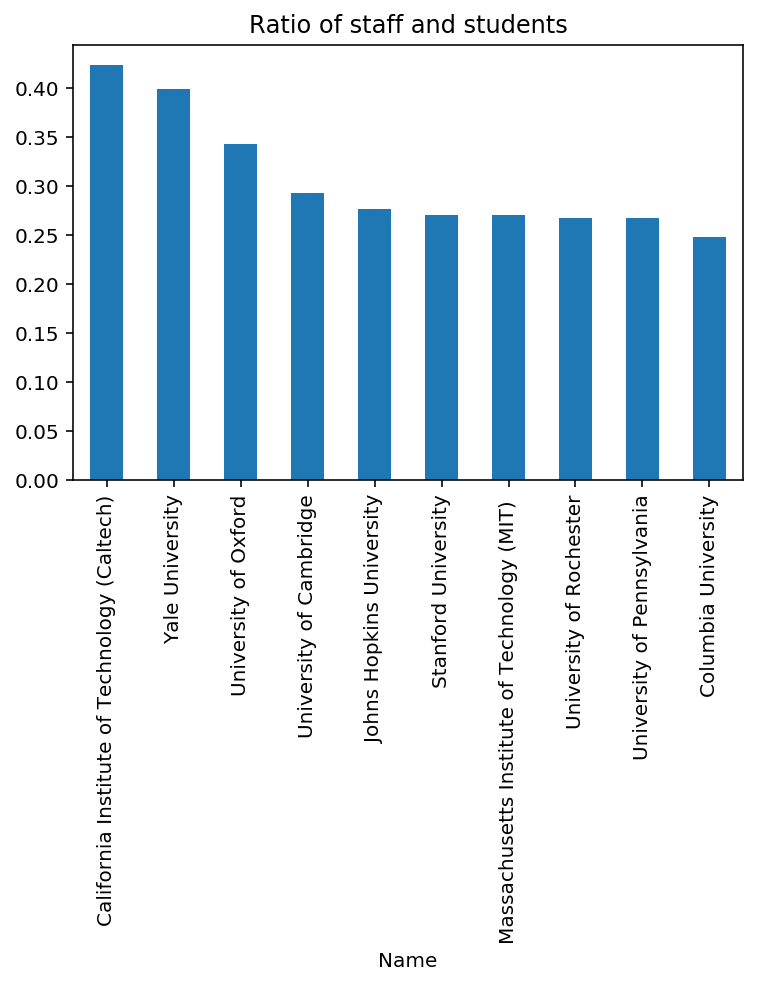

In [10]:
bar_chart_ratio(topuni_rat_staff_stud, "Ratio of staff and students", 10)

We can directly distinguish the 4 best universities in terms of the ratio of faculty members and students which are Caltech, Yale, Oxford and Cambridge from the rest of them.
### 1.2 Ratio of international students
Let's take a look at the best in terms of international students now.

In [11]:
topuni_rat_inter = get_df_ratio(df=top_uni_df[["International_Student", "Total_Student", "Country", "Region"]].copy(),
            ratio_name="Ratio of international students",
            first="International_Student",
            second="Total_Student")

topuni_rat_inter.head()

,International_Student,Total_Student,Country,Region,Ratio of international students
Name,,,,,
London School of Economics and Political Science (LSE),6748.0,9760.0,United Kingdom,Europe,0.691393
Ecole Polytechnique Fédérale de Lausanne (EPFL),5896.0,10343.0,Switzerland,Europe,0.570047
Imperial College London,8746.0,16090.0,United Kingdom,Europe,0.543567
Maastricht University,8234.0,16385.0,Netherlands,Europe,0.502533
Carnegie Mellon University,6385.0,13356.0,United States,North America,0.478062


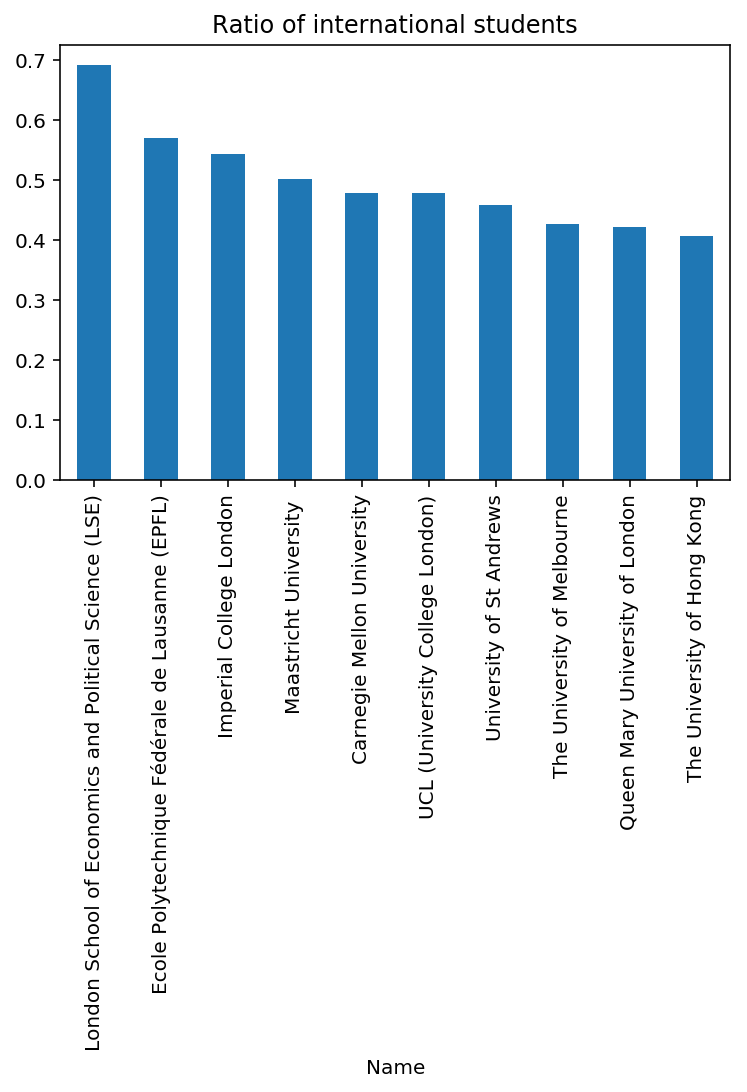

In [12]:
bar_chart_ratio(topuni_rat_inter, "Ratio of international students", 10)

Here it is less of a clear cut besides the first university. The 5 best universities in terms of the ratio of international students are LSE, EPFL, ICL, Maastricht University and CMU. Let's take a look at the same rankings but aggregated by Country and Region.
### 1.3 Aggregated by Country
#### 1.3.1 Ratio between faculty members and students

In [13]:
topuni_rat_staff_stud_country = get_df_ratio(df=top_uni_df[["Total_Staff", "Total_Student", "Country", "Region"]].copy(),
            ratio_name="Ratio of staff and students",
            first="Total_Staff",
            second="Total_Student",
            aggregate_by="Country")

topuni_rat_staff_stud_country

,Total_Staff,Total_Student,Ratio of staff and students
Country,,,
Russia,6709.0,30233.0,0.221910
Denmark,11916.0,67223.0,0.177261
Saudi Arabia,1062.0,6040.0,0.175828
Singapore,9444.0,58466.0,0.161530
Malaysia,2755.0,17902.0,0.153893
Japan,28395.0,186222.0,0.152479
South Korea,19851.0,140071.0,0.141721
Switzerland,15323.0,109112.0,0.140434
United Kingdom,79934.0,583621.0,0.136962


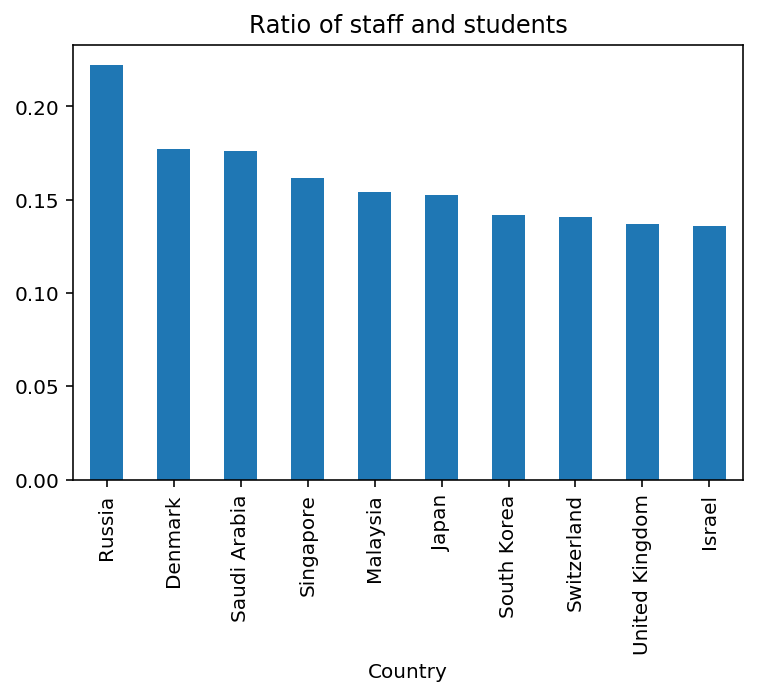

In [14]:
bar_chart_ratio(topuni_rat_staff_stud_country, "Ratio of staff and students", 10)

Again, countries here are closer to one another, even if Russia distances itself from the others. So, the 5 best countries in terms of the ratio of staff and students are Russia, Denmark, Saudi Arabia, Singapore and Malaysia. Surprisingly, the US are way down the list !

#### 1.3.2 Ratio of international students

In [15]:
topuni_rat_inter_country = get_df_ratio(df=top_uni_df[["International_Student", "Total_Student", "Country", "Region"]].copy(),
            ratio_name="Ratio of international students",
            first="International_Student",
            second="Total_Student",
            aggregate_by="Country")

topuni_rat_inter_country

,International_Student,Total_Student,Ratio of international students
Country,,,
Australia,106359.0,301994.0,0.352189
United Kingdom,199426.0,583621.0,0.341705
Hong Kong,24499.0,78838.0,0.310751
Austria,19667.0,63446.0,0.309980
Switzerland,32995.0,109112.0,0.302396
Singapore,16168.0,58466.0,0.276537
Canada,73239.0,281514.0,0.260161
New Zealand,12439.0,48173.0,0.258215
Ireland,8187.0,34794.0,0.235299


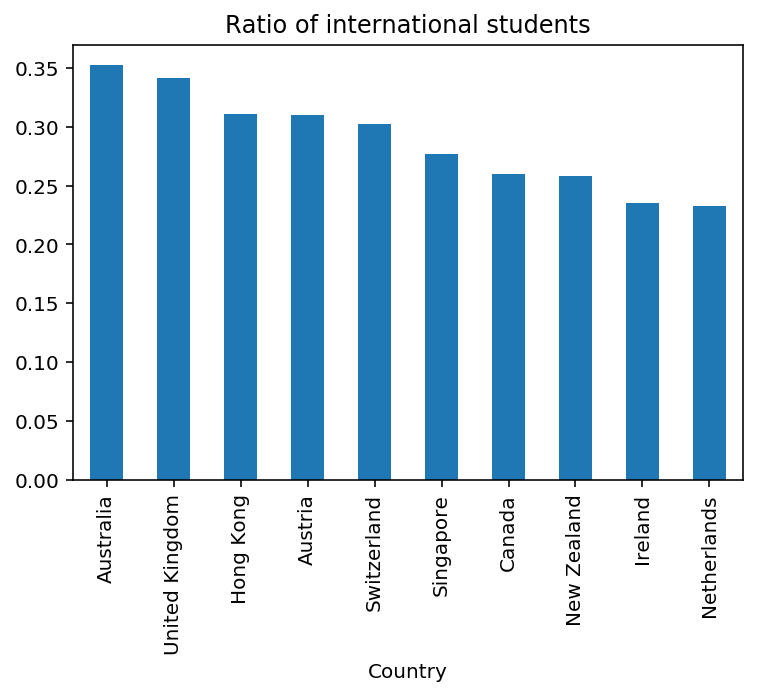

In [16]:
bar_chart_ratio(topuni_rat_inter_country, "Ratio of international students", 10)

Here it is again quite close, even if the 5 best countries distance themselves from the rest. These are Australia, the UK, Hong Kong, Austria and Switzerland ! How about aggregated by Region now.
### 1.4 Aggregated by Region
#### 1.4.1 Ratio between faculty members and students

In [17]:
topuni_rat_staff_stud_region = get_df_ratio(df=top_uni_df[["Total_Staff", "Total_Student", "Country", "Region"]].copy(),
            ratio_name="Ratio of staff and students",
            first="Total_Staff",
            second="Total_Student",
            aggregate_by="Region")

topuni_rat_staff_stud_region

,Total_Staff,Total_Student,Ratio of staff and students
Region,,,
Asia,106734.0,807003.0,0.132260
North America,182123.0,1546353.0,0.117776
Europe,218358.0,1957251.0,0.111564
Latin America,45382.0,435750.0,0.104147
Africa,1733.0,19593.0,0.088450
Oceania,25347.0,350167.0,0.072385


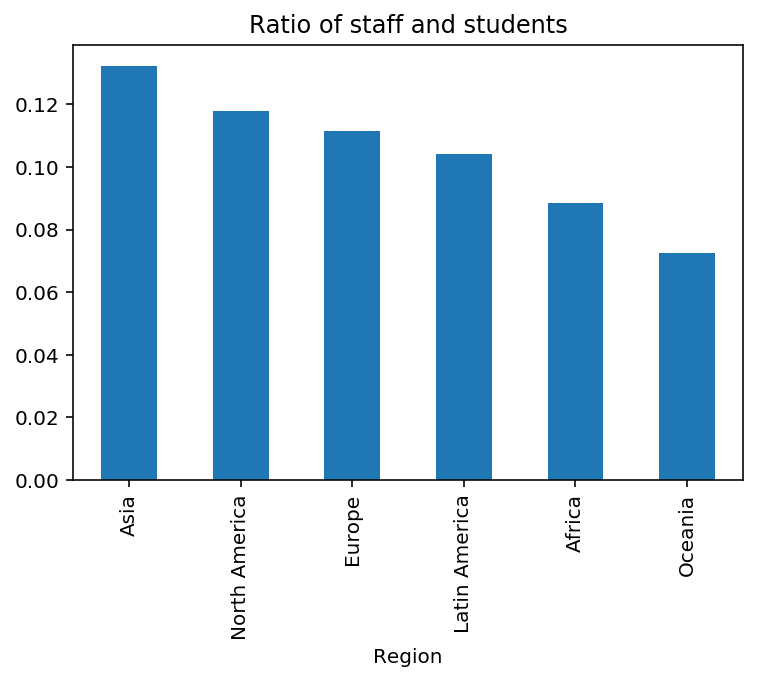

In [18]:
bar_chart_ratio(topuni_rat_staff_stud_region, "Ratio of staff and students", 10)

The 3 best regions in terms of ratio of staff and students are Asia, North America and Europe. But what about international students ?
#### 1.4.2 Ratio of international students

In [19]:
topuni_rat_inter_region = get_df_ratio(df=top_uni_df[["International_Student", "Total_Student", "Country", "Region"]].copy(),
            ratio_name="Ratio of international students",
            first="International_Student",
            second="Total_Student",
            aggregate_by="Region")

topuni_rat_inter_region

,International_Student,Total_Student,Ratio of international students
Region,,,
Oceania,118798.0,350167.0,0.339261
Europe,449364.0,1957251.0,0.229589
North America,292116.0,1546353.0,0.188906
Africa,3325.0,19593.0,0.169703
Asia,110100.0,807003.0,0.136431
Latin America,36871.0,435750.0,0.084615


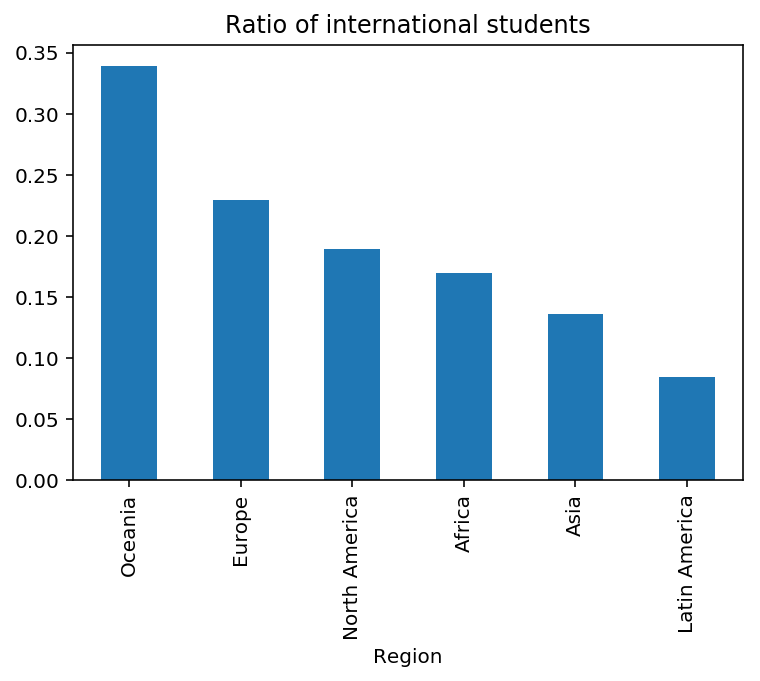

In [20]:
bar_chart_ratio(topuni_rat_inter_region, "Ratio of international students", 10)

Oceania is way ahead of the other regions in terms of international students, then we get Europe and North America. Europe and North America are really on top of the universities by different standards.
##  2. Getting the data from the Times Higher Education website

We did the same work with Postman, and find the following URL.

In [21]:
URL_timesHE = "https://www.timeshighereducation.com/sites/default/files/the_data_rankings/world_university_rankings_2018_limit0_369a9045a203e176392b9fb8f8c1cb2a.json"
r_timesHE = requests.get(URL_timesHE)
r_as_json_timesHE = r_timesHE.json()

In [22]:
# We are interested in the 200 top-ranking universities
timesHE_dict = r_as_json_timesHE['data'][:200]

In [23]:
# We create a pandas DataFrame with the json we got
timesHE_df = pd.DataFrame.from_dict(timesHE_dict)
# Only keeping the interesting columns
interesting_columns = ['name', 'location', 'rank', 'stats_number_students', 'stats_pc_intl_students', 'stats_student_staff_ratio']
timesHE_df = timesHE_df[interesting_columns]
# Setting the universities name as index
timesHE_df.set_index(['name'], inplace=True)
timesHE_df.head()

,location,rank,stats_number_students,stats_pc_intl_students,stats_student_staff_ratio
name,,,,,
University of Oxford,United Kingdom,1,"20,409",38%,11.2
University of Cambridge,United Kingdom,2,"18,389",35%,10.9
California Institute of Technology,United States,=3,"2,209",27%,6.5
Stanford University,United States,=3,"15,845",22%,7.5
Massachusetts Institute of Technology,United States,5,"11,177",34%,8.7


We can see that we have to process the dataframe values. In fact, we have to get the number of international students and staff according to the percentage and the ratio we have. 

In [24]:
# Let's change the type of our columns in order to use them as number
timesHE_df['stats_number_students'] = timesHE_df['stats_number_students'].str.replace(',','').astype(float)
timesHE_df['stats_pc_intl_students'] = timesHE_df['stats_pc_intl_students'].str.replace('%','').astype(float)
timesHE_df['stats_student_staff_ratio'] = timesHE_df['stats_student_staff_ratio'].astype(float)
timesHE_df['rank'] = timesHE_df['rank'].str.replace('=','').astype(int)

In [25]:
# Transforming columns from ratios to actual counts
timesHE_df['stats_pc_intl_students'] = timesHE_df['stats_number_students'] * timesHE_df['stats_pc_intl_students'] / 100
timesHE_df['stats_student_staff_ratio'] = timesHE_df['stats_number_students'] / timesHE_df['stats_student_staff_ratio']

In [26]:
# Assuming that it's impossible to have "parts" of a person, we round it all up
timesHE_df['stats_pc_intl_students'] = np.ceil(timesHE_df['stats_pc_intl_students'])
timesHE_df['stats_student_staff_ratio'] = np.ceil(timesHE_df['stats_student_staff_ratio'])

In [27]:
# Finally we rename our columns and index
timesHE_df.rename(columns={'location': 'Country', 'rank': 'Rank', 'stats_number_students': 'Total_Student','stats_pc_intl_students': 'International_Student', 'stats_student_staff_ratio': 'Total_Staff'}, inplace=True)
timesHE_df.index.names = ['Name']

In [28]:
timesHE_df

,Country,Rank,Total_Student,International_Student,Total_Staff
Name,,,,,
University of Oxford,United Kingdom,1,20409.0,7756.0,1823.0
University of Cambridge,United Kingdom,2,18389.0,6437.0,1688.0
California Institute of Technology,United States,3,2209.0,597.0,340.0
Stanford University,United States,3,15845.0,3486.0,2113.0
Massachusetts Institute of Technology,United States,5,11177.0,3801.0,1285.0
Harvard University,United States,6,20326.0,5285.0,2284.0
Princeton University,United States,7,7955.0,1910.0,959.0
Imperial College London,United Kingdom,8,15857.0,8722.0,1391.0
University of Chicago,United States,9,13525.0,3382.0,2182.0


### 2.1 Ratio between faculty members and students

We use the same function in order to get the ratios, ordered and groupby.

In [29]:
times_rat_staff_stud = get_df_ratio(df=timesHE_df[["Total_Staff", "Total_Student", "Country"]].copy(),
            ratio_name="Ratio of staff and students",
            first="Total_Staff",
            second="Total_Student")

times_rat_staff_stud.head()

,Total_Staff,Total_Student,Country,Ratio of staff and students
Name,,,,
Vanderbilt University,3640.0,12011.0,United States,0.303056
University of Copenhagen,7414.0,30395.0,Denmark,0.243922
Johns Hopkins University,3605.0,15498.0,United States,0.232611
Yale University,2827.0,12155.0,United States,0.232579
University of Rochester,2241.0,9636.0,United States,0.232565


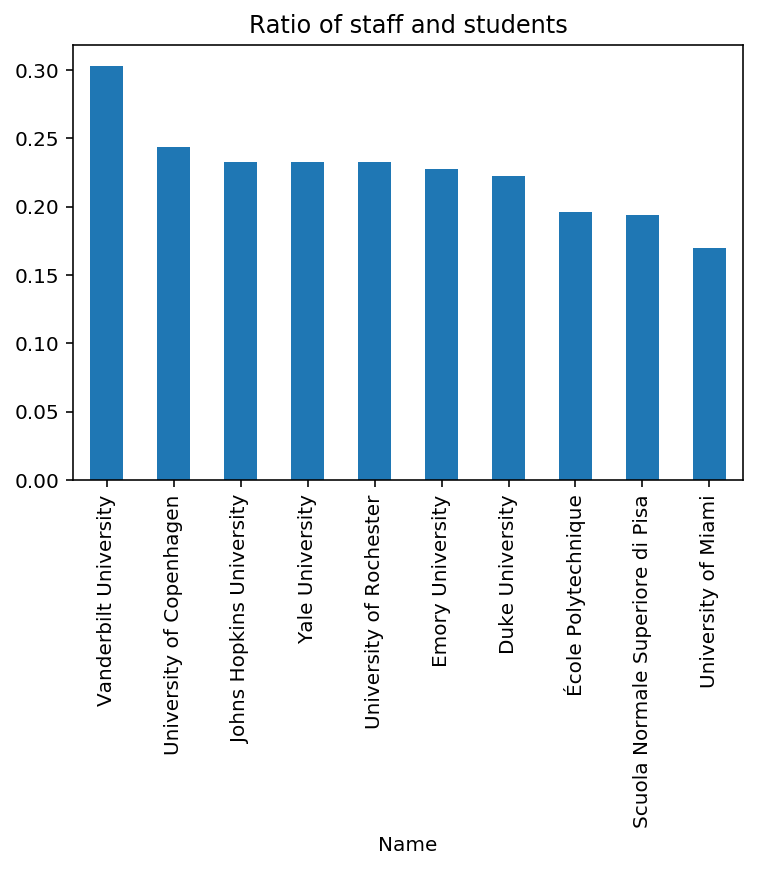

In [30]:
bar_chart_ratio(times_rat_staff_stud, ratio_name="Ratio of staff and students", quantity=10)

In this regard, Vanderbilt University distances itself from the others that are more equal. The 4 remaining best universities after Vanderbilt are: Copenhagen, Johns Hopkins, Yale and Rochester. Let's take a look at the best in terms of international students now.

### 2.2 Ratio of international students

In [31]:
times_rat_inter = get_df_ratio(df=timesHE_df[["International_Student", "Total_Student", "Country"]].copy(),
            ratio_name="Ratio of international students",
            first="International_Student",
            second="Total_Student")

times_rat_inter.head()

,International_Student,Total_Student,Country,Ratio of international students
Name,,,,
London School of Economics and Political Science,7147.0,10065.0,United Kingdom,0.710084
University of Luxembourg,2833.0,4969.0,Luxembourg,0.570135
École Polytechnique Fédérale de Lausanne,5461.0,9928.0,Switzerland,0.550060
Imperial College London,8722.0,15857.0,United Kingdom,0.550041
Maastricht University,8364.0,16727.0,Netherlands,0.500030


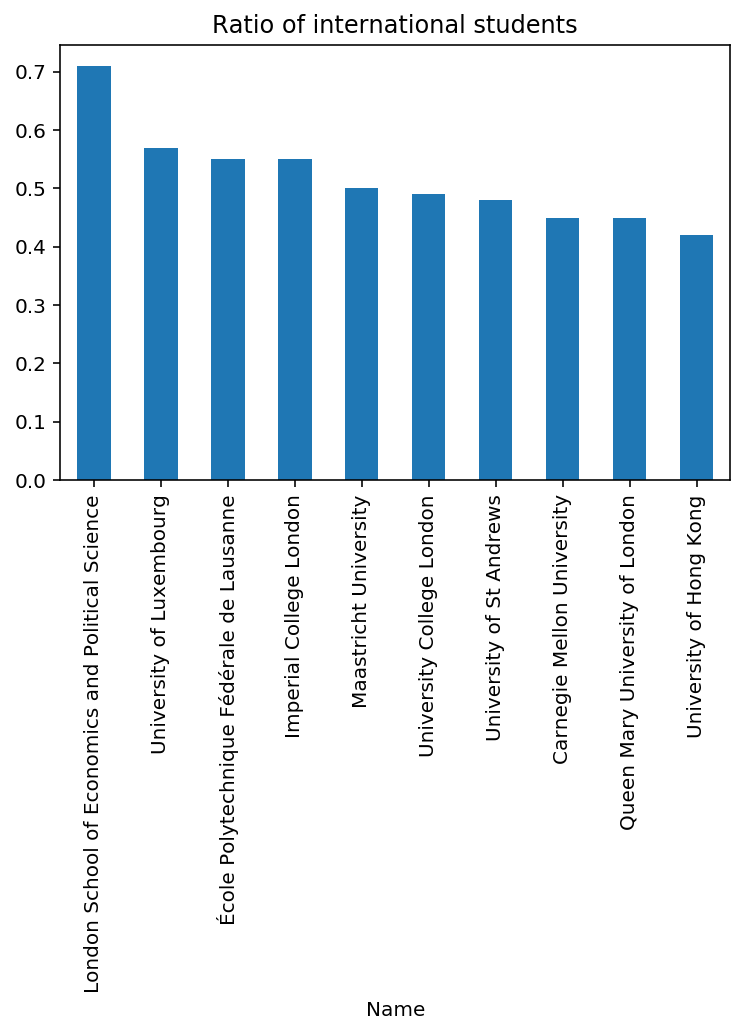

In [32]:
bar_chart_ratio(times_rat_inter, ratio_name="Ratio of international students", quantity=10)

Again, the London School of Economics and Political Science is not really close to the rest of the schools, and sits proudly at the place of most intenational university in terms of students. The other 4 best universities are the University of Luxembourg, EPFL, ICL, and Maastricht University. Let's take a look at the same rankings but aggregated by Country.
### 2.3 Aggregated by Country
#### 2.3.1 Ratio between faculty members and students

In [33]:
times_rat_staff_stud_country = get_df_ratio(df=timesHE_df[["Total_Staff", "Total_Student", "Country"]].copy(),
            ratio_name="Ratio of staff and students",
            first="Total_Staff",
            second="Total_Student",
            aggregate_by="Country")

times_rat_staff_stud_country

,Total_Staff,Total_Student,Ratio of staff and students
Country,,,
Denmark,10599.0,64110.0,0.165325
Russian Federation,4005.0,29236.0,0.136989
Japan,6466.0,48481.0,0.133372
Italy,159.0,1205.0,0.131950
Switzerland,10055.0,107852.0,0.093230
United States,152378.0,1705533.0,0.089343
Taiwan,2762.0,31758.0,0.086970
South Africa,1776.0,20775.0,0.085487
China,21395.0,253911.0,0.084262


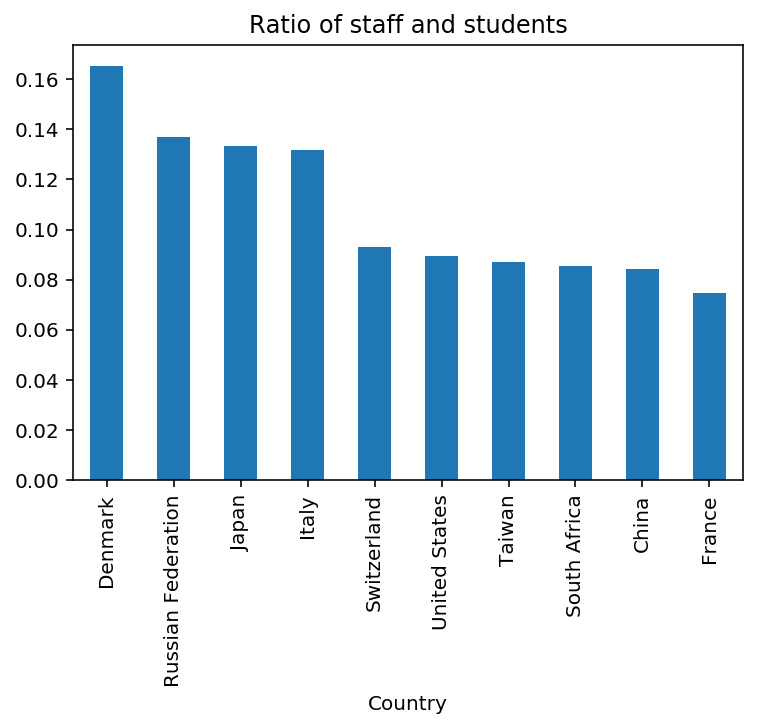

In [34]:
bar_chart_ratio(times_rat_staff_stud_country, "Ratio of staff and students", 10)

In terms of countries we can clearly see that the 4 best are a clear cur compared to the others. The 4 best countries in terms of the ratio of staff and students are Denmark, Russia, Japan and Italy. 

#### 2.3.2 Ratio of international students

In [35]:
times_rat_inter_country = get_df_ratio(df=timesHE_df[["International_Student", "Total_Student", "Country"]].copy(),
            ratio_name="Ratio of international students",
            first="International_Student",
            second="Total_Student",
            aggregate_by="Country")

times_rat_inter_country

,International_Student,Total_Student,Ratio of international students
Country,,,
Luxembourg,2833.0,4969.0,0.570135
United Kingdom,213076.0,596449.0,0.357241
Hong Kong,25161.0,77663.0,0.323977
Australia,83815.0,268630.0,0.312009
Singapore,17086.0,56101.0,0.304558
Switzerland,32749.0,107852.0,0.303648
New Zealand,8801.0,30348.0,0.290003
Ireland,4363.0,16157.0,0.270038
Austria,9198.0,35375.0,0.260014


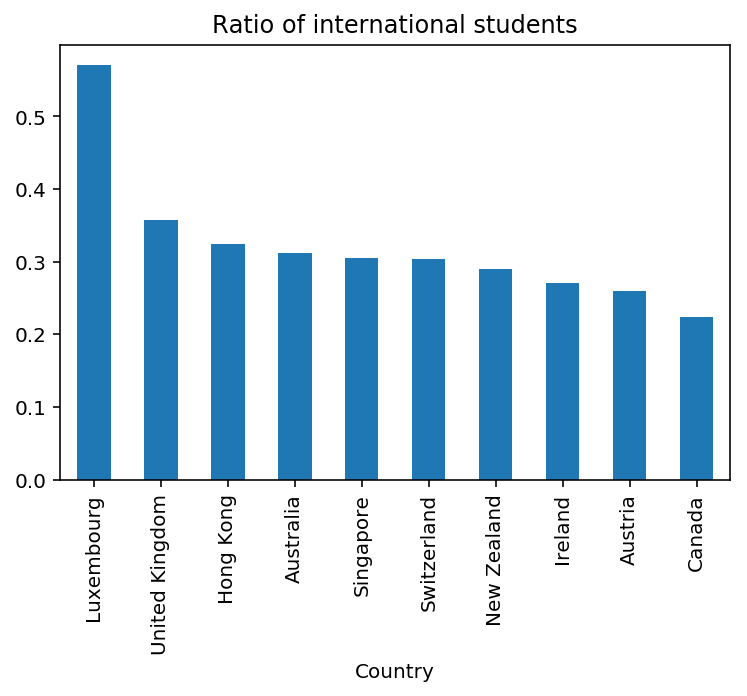

In [36]:
bar_chart_ratio(times_rat_inter_country, ratio_name="Ratio of international students", quantity=10)

Here, only the best one is way ahead compared to the others. Luxembourg is the country containing the best universities in terms of international students compared to national ones. The 4 best countries following are the UK, Hong Kong, Australia and Singapore.

## 3. Merging the DataFrames

Taking a look at the distribution of words in all of the university names:

In [37]:
def to_ascii(string):
    """
    We only use the unidecode import for this function,
    it helps decoding a string into its ascii representation
    
    Returns the string in ascii representation
    """
    return unidecode.unidecode(string)

total_unis = [ to_ascii(uni).strip().lower() for uni in list(top_uni_df.index) + list(timesHE_df.index)]
# Counter simply returns a dictionnary mapping its parameters
# one by one to their counts in the total text
count_mapping = Counter(" ".join(total_unis).split())
print(count_mapping)

Counter({'university': 326, 'of': 214, 'technology': 30, 'the': 23, 'institute': 19, 'de': 19, 'california,': 14, 'college': 13, 'science': 11, 'london': 10, 'hong': 10, 'kong': 10, 'and': 10, 'state': 10, 'national': 9, '-': 7, 'ecole': 7, 'berlin': 7, 'at': 6, 'zurich': 5, 'normale': 5, 'new': 5, 'technical': 5, 'universidad': 5, 'universite': 5, 'di': 5, 'california': 4, 'singapore': 4, 'polytechnique': 4, 'lausanne': 4, 'columbia': 4, 'pennsylvania': 4, 'michigan': 4, 'paris': 4, 'york': 4, 'washington': 4, 'texas': 4, 'universitat': 4, 'scuola': 4, 'superiore': 4, 'massachusetts': 3, 'tokyo': 3, 'korea': 3, '&': 3, 'sydney': 3, 'amsterdam': 3, 'munich': 3, 'birmingham': 3, 'dublin': 3, 'st': 3, 'western': 3, 'royal': 3, 'autonoma': 3, 'santa': 3, 'vienna': 3, 'barcelona': 3, 'indian': 3, 'pisa': 3, 'stanford': 2, 'harvard': 2, 'cambridge': 2, 'oxford': 2, 'imperial': 2, 'chicago': 2, 'eth': 2, 'swiss': 2, 'federal': 2, 'nanyang': 2, 'technological': 2, 'university,': 2, '(ntu)': 2

We can clearly see that there are a certain number of terms that we can tokenize in order for them not to have any importance in the similarity score that we will attribute each of them later on. We handpick them and replace them by determined single characters.

Hence in the following function, we remove any content inbetween parenthesis, any punctuation and finally anything below the size of 3 characters. In addition to these changes, we map the following terms and their translations this way: 
* Technical/Technology and its translations &rarr; t 
* University and its translations &rarr; u 
* College and its translations &rarr; c 
* Institute and its translations &rarr; i

In [38]:
def tokenize(some_string):
    """
    Tokenizes the string in argument. Namely removes the
    additional spaces, accents, and lower cases all of 
    the text. In addition, we map each of the most used terms
    and their translations to a token in order for them not
    to have a big importance in the similarity score
    
    Returns a tokenized sentence
    """
    # We needed to import the regex library in order to
    # do the mappings and replace in the string correctly
    # Removing accents, additional spaces, and lowers everything
    some_string = re.sub(r'^(.*?)\(.*?\)(.*?)$', r"\1 \2", some_string)
    some_string = re.sub(r'[\,\.\-\_\?]', " ", some_string)
    
    sanitized_list = to_ascii(some_string).strip().lower().split()
    # Tokenizes what needs to be
    tokenized_list = []
    for word in sanitized_list:
        if len(word) <= 3:
            continue
        # Tokenize all of the most used terms
        new_word = word
        new_word = re.sub(r'^tec.*$', "t", new_word)
        new_word = re.sub(r'^unive.*$', "u", new_word)
        new_word = re.sub(r'^coll.*$', "c", new_word)
        new_word = re.sub(r'^inst.*$', "i", new_word)
        
        tokenized_list.append(new_word)
            
    # Removes empty elements
    tokenized_list = [ token for token in tokenized_list if token != ""]
    return " ".join(tokenized_list)

In order to find the similarity inbetween two names we use SequenceMatcher. 
The function returns a measure of the sequences’ similarity as a float in the range [0, 1] where T is the total number of elements in both sequences, and M is the number of matches, this is 2.0*M / T. Note that this is 1.0 if the sequences are identical, and 0.0 if they have nothing in common.

In [39]:
def similar(a, b):
    """
    Returns the True if the two elements are close by an
    arbitrary ratio of 0.9 (the best value we tested out)
    """
    return SequenceMatcher(None, a, b).ratio() > 0.9

While doing this matching and merging the DataFrames, we stumbled upon two problems, false negatives and false positives. We discovered these errors by checking the merge by hand, since the dataset is not that big. What we mean by that is the following: in the case of false negatives, these are pairs that were not matched together but should have been. There are only 6 false negative pairs that we met. What we do in the following cell is first replace the Names of the false negatives by an exact match so that they will not be forgotten at merge time, and then tokenize the universities names to set them as an index.

In [40]:
timesHE_merge_df = timesHE_df.copy().reset_index()
top_uni_merge_df = top_uni_df.copy().reset_index()

# Change the name of some universities by hand to obtain a perfect match
# (These are the false negatives we were just talking about)
name_mapping = {"Name":
                    {"LMU Munich": "Ludwig-Maximilians-Universität München",
                     "Scuola Superiore Sant’Anna": "Scuola Superiore Sant\'Anna Pisa di Studi Universitari e di Perfezionamento",
                     "ETH Zurich – Swiss Federal Institute of Technology Zurich": "ETH Zurich – Swiss Federal Institute of Technology",
                     "UCL (University College London)": "University College London",
                     "KAIST - Korea Advanced Institute of Science & Technology": "Korea Avanced Institute of Science & Technology (KAIST)",
                     "Trinity College Dublin, The University of Dublin": "Trinity College Dublin"
                    }
               }
timesHE_merge_df = timesHE_merge_df.replace(to_replace=name_mapping)
top_uni_merge_df = top_uni_merge_df.replace(to_replace=name_mapping)

# We tokenize the universities' name of the dataFrames we get from www.topuniversities.com 
# and www.timeshighereducation.com in order to easily compare them and merge them according to their similarity.
timesHE_merge_df['Tok_Name'] = timesHE_merge_df.Name.map(tokenize)
top_uni_merge_df['Tok_Name'] = top_uni_merge_df.Name.map(tokenize)

timesHE_merge_df.set_index('Tok_Name', inplace=True)
top_uni_merge_df.set_index('Tok_Name', inplace=True)

Now, onto the false positive problem, what we mean by false positive is universities merged that should not have been merged. It only happens once, in fact we merged by error the universities of Northwestern and Northeastern. In order to fix this issue, we simply replace the tokens by an exact match again, "n west u" for Northwestern and "n east u" for Northeastern. This solves it and we have no longer any merge problems.

In [41]:
timesHE_merge_df = timesHE_merge_df.rename({"northwestern u": "n west u", "northeastern u": "n east u"})
top_uni_merge_df = top_uni_merge_df.rename({"northwestern u": "n west u", "northeastern u": "n east u"})

We compare each row of our dataFrames according to their tokenize name. If they are sufficiently close according to our similarity function therefore we set them with the same index.

In [42]:
for ia, rowa in timesHE_merge_df.iterrows():
    for ib, rowb in top_uni_merge_df.iterrows():
        if similar(ia, ib):
            top_uni_merge_df.rename(index={ib: ia}, inplace=True)

Then we merge our dataFrames:
<br>
We combine the rows with same index, and create new rows for universities that appear in only one dataFrame.

In [43]:
# Merging the dataframes
merge_df = pd.merge(timesHE_merge_df, top_uni_merge_df, left_index=True, right_index=True, how='outer', suffixes=['_timesHE', '_topUni'])
merge_df.sort_index().head()

,Name_timesHE,Country_timesHE,Rank_timesHE,Total_Student_timesHE,International_Student_timesHE,Total_Staff_timesHE,Name_topUni,Rank_topUni,Region,Country_topUni,Total_Student_topUni,International_Student_topUni,Total_Staff_topUni,International_Staff
Tok_Name,,,,,,,,,,,,,,
aalto u,Aalto University,Finland,190.0,12744.0,2549.0,631.0,Aalto University,137.0,Europe,Finland,12147.0,1831.0,1257.0,370.0
aarhus u,Aarhus University,Denmark,109.0,25167.0,3021.0,1760.0,Aarhus University,119.0,Europe,Denmark,26226.0,3762.0,2316.0,602.0
albert ludwigs u freiburg,NaN,NaN,NaN,NaN,NaN,NaN,Albert-Ludwigs-Universitaet Freiburg,171.0,Europe,Germany,23214.0,3897.0,1966.0,413.0
alma mater studiorum u bologna,NaN,NaN,NaN,NaN,NaN,NaN,Alma Mater Studiorum - University of Bologna,188.0,Europe,Italy,63399.0,4195.0,2990.0,153.0
arizona state u,Arizona State University,United States,126.0,44475.0,8451.0,2213.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


We want to set the name of the universities as index for our final dataFrame.
<br>
Therefore, if a university appears in the two rankings we arbitrarly decide to keep the longest name of both, the one that is more likely to contain the most information.

In [44]:
# Comparing the name sizes of both dataframes
nameCond = merge_df['Name_timesHE'].str.len().fillna(0)>merge_df['Name_topUni'].str.len().fillna(0)
# Storing the best name
merge_df['Name'] = np.where(nameCond, merge_df['Name_timesHE'], merge_df['Name_topUni'])
merge_df.set_index('Name', inplace=True)

# Removing unnecessary columns
merge_df = merge_df.drop(['Name_timesHE', 'Name_topUni'], axis=1)

# Renaming the InternationalStaff
merge_df.rename(columns={"International_Staff": "International_Staff_topUni"}, inplace=True)

merge_df.sort_index()

,Country_timesHE,Rank_timesHE,Total_Student_timesHE,International_Student_timesHE,Total_Staff_timesHE,Rank_topUni,Region,Country_topUni,Total_Student_topUni,International_Student_topUni,Total_Staff_topUni,International_Staff_topUni
Name,,,,,,,,,,,,
Aalto University,Finland,190.0,12744.0,2549.0,631.0,137.0,Europe,Finland,12147.0,1831.0,1257.0,370.0
Aarhus University,Denmark,109.0,25167.0,3021.0,1760.0,119.0,Europe,Denmark,26226.0,3762.0,2316.0,602.0
Albert-Ludwigs-Universitaet Freiburg,NaN,NaN,NaN,NaN,NaN,171.0,Europe,Germany,23214.0,3897.0,1966.0,413.0
Alma Mater Studiorum - University of Bologna,NaN,NaN,NaN,NaN,NaN,188.0,Europe,Italy,63399.0,4195.0,2990.0,153.0
Arizona State University,United States,126.0,44475.0,8451.0,2213.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Autonomous University of Barcelona,Spain,147.0,32309.0,5170.0,2505.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Boston University,United States,70.0,24833.0,6209.0,2888.0,81.0,North America,United States,25662.0,7041.0,3157.0,379.0
Brown University,United States,50.0,8898.0,1780.0,832.0,53.0,North America,United States,9251.0,1825.0,1303.0,379.0
California Institute of Technology (Caltech),United States,3.0,2209.0,597.0,340.0,4.0,North America,United States,2255.0,647.0,953.0,350.0


## 4. Exploratory Analysis
We are going to look at a few things to explore the data.

### 4.1. Comparison between the two websites

We are going to compare the results of the two websites.
Thus, we compute the 'distances' between each corresponding columns.
For example the distance between the rank of EPFL according to each site.
Then, we compute the mean of all thoses distances in order to get an idea of the global difference of the two websites.

In [45]:
merge_df_analysis = merge_df.copy()
merge_df_analysis = merge_df_analysis.sort_values(by='Rank_timesHE')
# The dict of the columns we want to substract in order to get our distance
to_diff = {'Rank':['Rank_timesHE','Rank_topUni'], 
                'Number of Students':['Total_Student_timesHE','Total_Student_topUni'], 
                'Number of International Students': ('International_Student_timesHE','International_Student_topUni'), 
                'Number of Staff': ['Total_Staff_timesHE','Total_Staff_topUni']}

diff_mean_df = pd.DataFrame()
diff50_mean_df = pd.DataFrame()

for i in to_diff:
    # we get our distances
    diff_mean_df[i] = np.abs(merge_df_analysis[to_diff[i][0]] - merge_df_analysis[to_diff[i][1]])
    diff50_mean_df[i] = np.abs(merge_df_analysis[to_diff[i][0]][:50] - merge_df_analysis[to_diff[i][1]][:50])

# mean for each distance
print('Mean of the difference between the two websites for all universities \n')
print(diff_mean_df.dropna().mean(), '\n')
print('---------------- \n')
print('And for the 50 first ones \n')
print(diff50_mean_df.dropna().mean())

Mean of the difference between the two websites for all universities 

Rank                                  32.039216
Number of Students                  1279.490196
Number of International Students     670.026144
Number of Staff                     1172.006536
dtype: float64 

---------------- 

And for the 50 first ones 

Rank                                  12.468085
Number of Students                  1146.744681
Number of International Students     696.361702
Number of Staff                     1653.297872
dtype: float64


As we can see, the two websites are not really consistent. But it can be explained for some columns.

For the ranking, the two websites have certainly different ways to compute an university score. However we can see that the 50 first universities are globaly closer to their corresponding ranks (it varies with a mean of 12 ranks instead of 32). Thus, a well ranked university for one website, as more chance to have a similar rank according to the other one.

For the other distances, it seems that there are few differences wether we look for the whole dataFrame or for the 50 first universities.

For the number of students, and faculty members we can imagine that the two websites consider different definitions. It is striking for the number of faculty members given that they are fewer than students. Therefore the mean is particularly high. This could be explained, for example, if one website considers only the teachers as faculty members, and the other one, all the people that is not a student and works in the university.

### 4.2. Ratio analysis setup
We have also decided to analyze the ratio between faculty members and students, of international students and international faculty member.
<br>
Moreover we will also normalize all the columns.

In [46]:
merge_float_df = merge_df.drop(['Country_timesHE', 'Country_topUni', 'Region'], axis=1)

# Dict of the interesting ratios
ratio_todo = {"Ratio_staff_students_timesHE": ["Total_Staff_timesHE", "Total_Student_timesHE"], 
              "Ratio_international_students_timesHE": ["International_Student_timesHE", "Total_Student_timesHE"],
              "Ratio_staff_students_topUni": ["Total_Staff_topUni", "Total_Student_topUni"], 
              "Ratio_international_students_topUni": ["International_Student_topUni", "Total_Student_topUni"],
              "Ratio_international_staff_topUni": ["International_Staff_topUni", "Total_Student_topUni"]}

merge_ratio_df = merge_float_df.copy()

# We create a new dataframe with the ratios as new columns
# We use the same function that we used for questions 1 and 2
for i in ratio_todo:
    merge_ratio_df = get_df_ratio(df=merge_ratio_df.copy(),
            ratio_name=i,
            first=ratio_todo[i][0],
            second=ratio_todo[i][1])
    
# We get the dataframe of ratios
merge_onlyratio_df = merge_ratio_df[list(ratio_todo.keys())]

# We normalize our columns
merge_ssratio_norm_df = (merge_float_df-merge_float_df.min())/(merge_float_df.max()-merge_float_df.min())

# We create our final dataframe
merge_ratio_df = pd.concat([merge_ssratio_norm_df,merge_onlyratio_df], axis=1)
merge_ratio_df.head()

,Rank_timesHE,Total_Student_timesHE,International_Student_timesHE,Total_Staff_timesHE,Rank_topUni,Total_Student_topUni,International_Student_topUni,Total_Staff_topUni,International_Staff_topUni,Ratio_staff_students_timesHE,Ratio_international_students_timesHE,Ratio_staff_students_topUni,Ratio_international_students_topUni,Ratio_international_staff_topUni
Aalto University,0.959391,0.177458,0.149435,0.077770,0.680,0.082139,0.065923,0.071687,0.094750,0.049513,0.200016,0.103482,0.150737,0.030460
Aarhus University,0.548223,0.357732,0.177513,0.231271,0.590,0.181702,0.137277,0.136517,0.154161,0.069933,0.120038,0.088309,0.143445,0.022954
Albert-Ludwigs-Universitaet Freiburg,NaN,NaN,NaN,NaN,0.850,0.160402,0.142266,0.115090,0.105762,NaN,NaN,0.084690,0.167873,0.017791
Alma Mater Studiorum - University of Bologna,NaN,NaN,NaN,NaN,0.935,0.444582,0.153278,0.177778,0.039181,NaN,NaN,0.047162,0.066168,0.002413
Arizona State University,0.634518,0.637915,0.500535,0.292862,NaN,NaN,NaN,NaN,NaN,0.049758,0.190017,NaN,NaN,NaN


### 4.3 Correlation inbetween ratios

Let's take a look at the correlations inbetween some ratios

In [47]:
ratio_df = merge_ratio_df[['Ratio_international_students_timesHE', 'Ratio_international_students_topUni']]
mean_ratio_international = ratio_df.mean(0)
print(mean_ratio_international)
rank_timesHE_df = merge_ratio_df[['Rank_timesHE', 'Ratio_international_students_timesHE']]
rank_timesHE_df = rank_timesHE_df.sort_values(by='Rank_timesHE').head(10)
mean_timesHE_international = rank_timesHE_df['Ratio_international_students_timesHE'].mean()

rank_topUni_df = merge_ratio_df[['Rank_topUni', 'Ratio_international_students_topUni']]
rank_topUni_df = rank_topUni_df.sort_values(by='Rank_topUni').head(10)
mean_topUni_international = rank_topUni_df['Ratio_international_students_topUni'].mean()
print('Mean of ratio students/international_students for the top 10 of timesHE: ', mean_timesHE_international)
print('Mean of ratio students/international_students for the top 10 of topUni: ', mean_topUni_international)

Ratio_international_students_timesHE    0.218690
Ratio_international_students_topUni     0.210753
dtype: float64
Mean of ratio students/international_students for the top 10 of timesHE:  0.306066046176
Mean of ratio students/international_students for the top 10 of topUni:  0.346717757903


We can see that if the university is ranked high, its proportion of international students is also quite high.

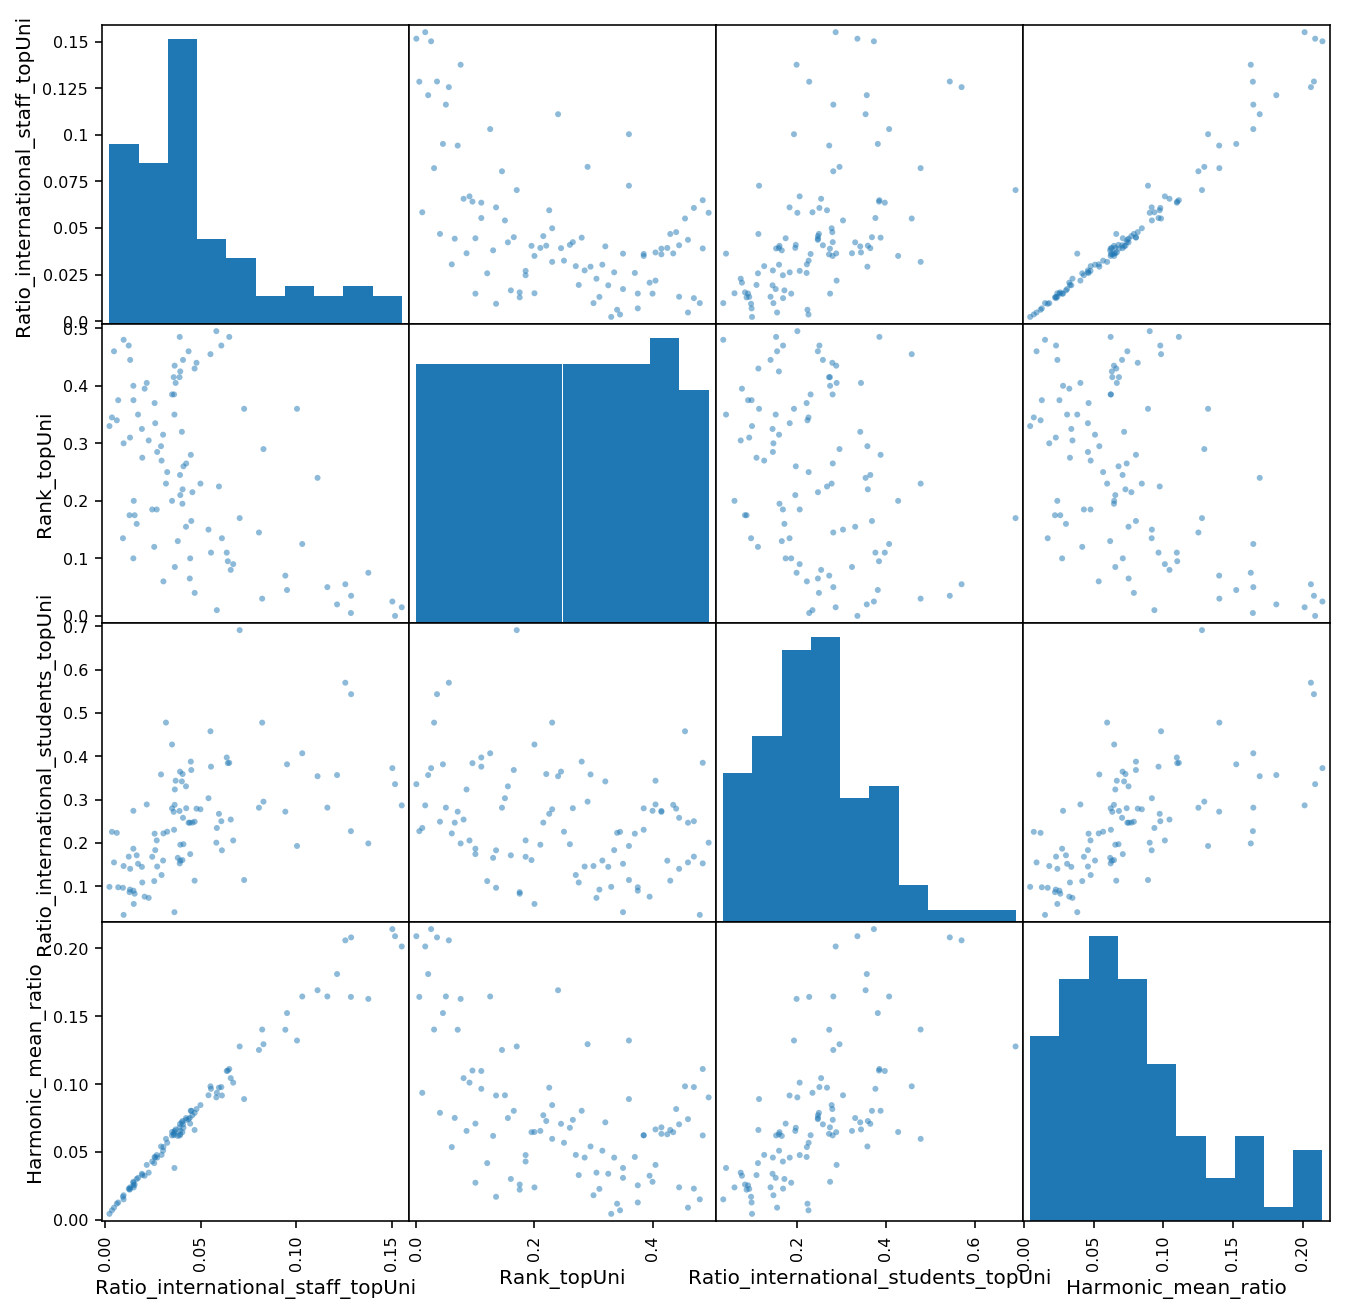

In [48]:
#Here we compute the harmonic mean between the ratio of international staff and the ratio of international students.
#Then we compute the correlation between the rank and this new column.
corr_df = merge_ratio_df[['Ratio_international_staff_topUni', 'Rank_topUni', 'Ratio_international_students_topUni']].copy()
corr_df['Harmonic_mean_ratio'] = 2 / ((1 / corr_df['Ratio_international_staff_topUni']) + (1 / corr_df['Ratio_international_students_topUni']))
corr_df = corr_df.sort_values(by='Rank_topUni').head(100)
scatter_matrix(corr_df, figsize=(11, 11))
plt.show()

With the plot we can see that the rank and the harmonic mean are correlated (second row, fourth column). So it confirms what we said earlier that the best universities have an higher proportion of internationals staff/students than the rest

### 4.4 Columns correlations
We decide to look for the pearson correlations between all columns.
<br>
First of all, we separate the two websites. Then we make it for the entire dataFrame.

In [49]:
THE_df = merge_df[['Rank_timesHE', 'Total_Student_timesHE',
       'International_Student_timesHE', 'Total_Staff_timesHE']]
TOPUNI_df = merge_df[['Rank_topUni','Total_Student_topUni','International_Student_topUni', 
        'Total_Staff_topUni', 'International_Staff_topUni']]

In [50]:
THE_corr_df = THE_df.corr().abs()
THE_corr_df

,Rank_timesHE,Total_Student_timesHE,International_Student_timesHE,Total_Staff_timesHE
Rank_timesHE,1.000000,0.151891,0.328151,0.248860
Total_Student_timesHE,0.151891,1.000000,0.578364,0.568355
International_Student_timesHE,0.328151,0.578364,1.000000,0.275580
Total_Staff_timesHE,0.248860,0.568355,0.275580,1.000000


In [51]:
TOPUNI_corr_df = TOPUNI_df.corr().abs()
TOPUNI_corr_df

,Rank_topUni,Total_Student_topUni,International_Student_topUni,Total_Staff_topUni,International_Staff_topUni
Rank_topUni,1.000000,0.039802,0.309609,0.316445,0.538667
Total_Student_topUni,0.039802,1.000000,0.558612,0.764622,0.312362
International_Student_topUni,0.309609,0.558612,1.000000,0.471808,0.643919
Total_Staff_topUni,0.316445,0.764622,0.471808,1.000000,0.593232
International_Staff_topUni,0.538667,0.312362,0.643919,0.593232,1.000000


We can see that the rank has maximum correlation with the international dimension of the universities (students and faculty members).

Then, each international numbers are obviously well correlated with their corresponding number (international students with students, inernational staff with staff). Thus, the more students an university has, the more it welcomes foreign students (or faculty members).

Finally, number of students and number of staff are well correlated. Again, obviously, when we have a lot of students, we need a lot of staff.

In [52]:
merge_num_df = merge_ratio_df[['Rank_timesHE', 'Total_Student_timesHE',
       'International_Student_timesHE', 'Total_Staff_timesHE', 'Rank_topUni',
       'Total_Student_topUni','International_Student_topUni', 'Total_Staff_topUni',
       'International_Staff_topUni']]


In [53]:
corr_df = merge_num_df.corr().abs()
corr_df

,Rank_timesHE,Total_Student_timesHE,International_Student_timesHE,Total_Staff_timesHE,Rank_topUni,Total_Student_topUni,International_Student_topUni,Total_Staff_topUni,International_Staff_topUni
Rank_timesHE,1.000000,0.151891,0.328151,0.248860,0.699166,0.155309,0.253145,0.364532,0.361351
Total_Student_timesHE,0.151891,1.000000,0.578364,0.568355,0.027854,0.982828,0.581042,0.606605,0.283807
International_Student_timesHE,0.328151,0.578364,1.000000,0.275580,0.279940,0.580069,0.927128,0.394977,0.546588
Total_Staff_timesHE,0.248860,0.568355,0.275580,1.000000,0.256144,0.523139,0.184373,0.753507,0.305452
Rank_topUni,0.699166,0.027854,0.279940,0.256144,1.000000,0.039802,0.309609,0.316445,0.538667
Total_Student_topUni,0.155309,0.982828,0.580069,0.523139,0.039802,1.000000,0.558612,0.764622,0.312362
International_Student_topUni,0.253145,0.581042,0.927128,0.184373,0.309609,0.558612,1.000000,0.471808,0.643919
Total_Staff_topUni,0.364532,0.606605,0.394977,0.753507,0.316445,0.764622,0.471808,1.000000,0.593232
International_Staff_topUni,0.361351,0.283807,0.546588,0.305452,0.538667,0.312362,0.643919,0.593232,1.000000


In addition of what we have noticed for each website, we can observe that each column for a given website is well correlated with its corresponding one for the other website.

Thus, even if the two rankings can be different for a given university as we have seen previously, it grows similarly for the two websites. 

Moreover even if the number of people (students, faculty members or internationals) in an university is different between the two websites, it's probably due to the way each website compute these numbers (it stays proportional).

### 4.5 Clustering the universities
Let's take a look at a good old k-means. We start by reducing the dimensions of our data to 2 by doing a PCA in order to plot them and have a clear dataset on which to run k-means. For this part we will only focus on the top Universities website in order to see how they are able to come up with a ranking.

In [54]:
# Take only the columns of top universities to start
topUni_cols = [col for col in merge_ratio_df.columns if 'topUni' in col]
# We want to find out how the rank is given, so we remove it
df_to_pca = merge_ratio_df[topUni_cols].drop(['Rank_topUni'], axis=1)
# We will work with the following DataFrame
df_to_pca = df_to_pca.dropna()

Let's apply a Principle Component Analysis on the universities to reduce the number of columns to two.

In [55]:
pca = PCA(n_components=2)
pca.fit(df_to_pca.T)
variance_explained = pca.explained_variance_ratio_*100
print("So the PCA explains: {:.2f}% and {:.2f}% of variance for the first and second components".format(variance_explained[0], variance_explained[1]))

So the PCA explains: 43.58% and 27.56% of variance for the first and second components


We want to apply k-means to find a good clustering of the data. Hence we focus first on finding the best k to use. In order to do so, we will use the elbow method.

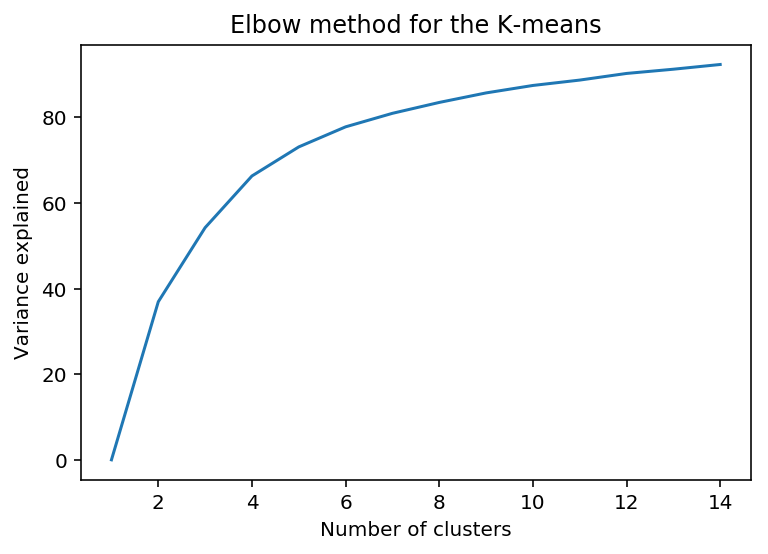

In [56]:
# Trying out 14 different values for k.
ks = range(1, 15)
km = [KMeans(n_clusters=i) for i in ks]
score = np.array([kmean.fit(pca.components_.T).score(pca.components_.T) for kmean in km])
variance_explained = [ (s-score.min())/np.abs(score.min())*100 for s in score ]

plt.plot(ks, variance_explained)
plt.title("Elbow method for the K-means")
plt.xlabel("Number of clusters")
plt.ylabel("Variance explained")
plt.show()

We can see that the best k to choose is $k=4$ since it explains $67\%$ of the variance and then the added clusters do not help gaining that much more information. Let's apply a k-means with $k=4$ on our universities.

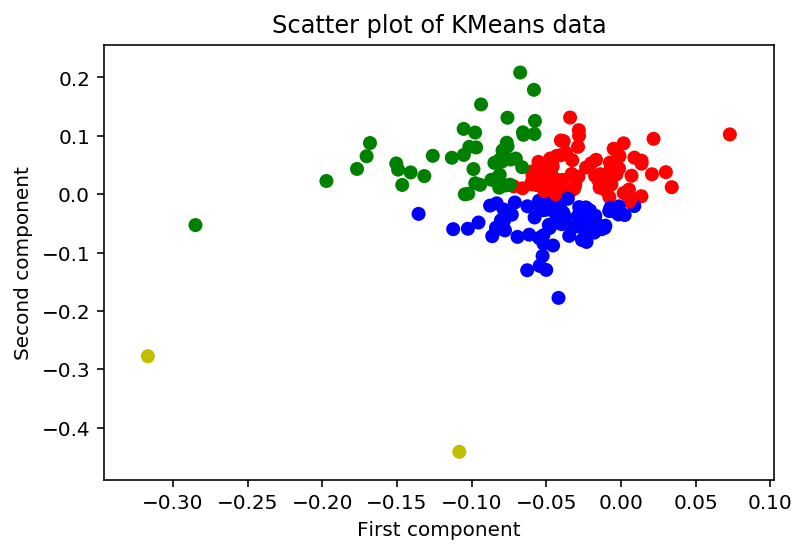

In [57]:
# Fitting kmeans to our pca components
clusters = KMeans(n_clusters=4).fit(pca.components_.T)
# We give a color to each cluster
colors_mapping = {0: 'r', 1:'b', 2:'g', 3:'y'}
mapping_colors = [ colors_mapping[i] for i in clusters.labels_ ]
# Let's plot it
plt.scatter(pca.components_[0], pca.components_[1], c=mapping_colors)
plt.title("Scatter plot of KMeans data")
plt.xlabel("First component")
plt.ylabel("Second component")
plt.show()

First, we see that one of the clusters is composed of outliers, kmeans could not give us a satisfactory cluster split for $k=3$, hence we simply disregard them.

In [58]:
df_clustered = df_to_pca.copy()
df_clustered['Cluster_Number'] = clusters.labels_
# Disregarding the outliers
df_clustered = df_clustered[df_clustered.Cluster_Number != 3]

We will now take a look at which universities belong to which cluster and try to find how to explain the dimensions used to create the clusters. Let's start by taking a look at the international dimension.

In [59]:
df_clustered = df_to_pca.copy()
df_clustered['Cluster_Number'] = clusters.labels_
    
def ratio_classifier(ratio):
    """
    Sorts a ratio to a categorical value, one per
    quantile. From Least International to Most
    International.
    
    Returns the categorical value
    """
    if ratio < 0.025:
        return "Least International"
    elif ratio >= 0.025 and ratio < 0.052:
        return "Less International"
    elif ratio >= 0.052 and ratio < 0.075:
        return "More International"
    if ratio >= 0.075:
        return "Most International"
    
# To create an international dimension, we take the
# harmonic mean of the two international ratios we have
# (we cant take the mean since they are ratios)
df_clustered['Harmonic_mean_inter'] = 2 / ((1.0 / df_clustered.Ratio_international_students_topUni) + (1.0 / df_clustered.Ratio_international_staff_topUni))
df_clustered['Inter_Ratio_Category'] = df_clustered.Harmonic_mean_inter.apply(ratio_classifier)
df_clustered.index = df_clustered.index.rename(name="University")
df_clustered = df_clustered.reset_index()
df_clustered = df_clustered.set_index(['Cluster_Number'])

dict_clusters = { nb_cluster: df_clustered.Inter_Ratio_Category[nb_cluster].values for nb_cluster in range(4) }
dict_clusters = {k: dict(Counter(v)) for k,v in dict_clusters.items()}#Here we compare the mean of the ratio of international students to the same mean but for the top 10 universities

Ok, now that we have our clusters and international dimension, let's see if they match:

In [60]:
for cluster in dict_clusters.keys():
    # Let's not take the cluster of outliers
    if cluster != 3:
        print("For the cluster number {}, we have:".format(cluster + 1))
        for category, count in dict_clusters[cluster].items():
                print("\t- {} universities categorized as {}".format(count, category))

For the cluster number 1, we have:
	- 15 universities categorized as Less International
	- 25 universities categorized as More International
	- 27 universities categorized as Most International
	- 9 universities categorized as Least International
For the cluster number 2, we have:
	- 31 universities categorized as Less International
	- 37 universities categorized as Least International
	- 7 universities categorized as More International
	- 1 universities categorized as Most International
For the cluster number 3, we have:
	- 17 universities categorized as More International
	- 23 universities categorized as Most International
	- 4 universities categorized as Less International
	- 1 universities categorized as Least International


And lo and behold, the three clusters explain perfectly how the ranking has been made. So the first component of the PCA at least contains a concept or dimension of internationality. Which means that best universities have a good ratio of international students and staff !

We did not do the PCA on the other ranking website, however we assume that the ranking would also show a link with the internationality of the university.

## 5. Best university
Let's sort the universities by their mean score in order to find out which university is the best of all. Here, we consider the ranks to be like rates, which means that the mean inbetween each rank computed should be the Harmonic mean. Moreover, for the universities where we only have a ranking for a single ranking site, we assume that the university in fact exists in the ranking, but is simply not in the top 200. With that assumption, we decided to weight each of them as being rank 201 in place of the missing ranking. This way we weigh down all universities that appear in one rank and not the other.

In [61]:
# Replacing missing values by rank number 201
rank = merge_df[['Rank_timesHE', 'Rank_topUni' ]].fillna(201)
# Computing the Harmonic Mean
rank['True_rank'] = 2 / ((1.0 / rank['Rank_timesHE']) + (1.0 / rank["Rank_topUni"]))
rank.sort_values(by='True_rank', inplace=True)
rank

,Rank_timesHE,Rank_topUni,True_rank
Name,,,
Massachusetts Institute of Technology (MIT),5.0,1.0,1.666667
University of Oxford,1.0,6.0,1.714286
Stanford University,3.0,2.0,2.400000
University of Cambridge,2.0,5.0,2.857143
California Institute of Technology (Caltech),3.0,4.0,3.428571
Harvard University,6.0,3.0,4.000000
Imperial College London,8.0,8.0,8.000000
University of Chicago,9.0,9.0,9.000000
Princeton University,7.0,13.0,9.100000


It seems like the top University is MIT ! If we were to round up the results, we would have MIT and Oxford ex aqueo.